## Delete components od directory


In [1]:
import os
import shutil

# Define paths to the output directories and ZIP files
augmented_images_dir = '/kaggle/working/augmented_images'
augmented_labels_dir = '/kaggle/working/augmented_labels'
augmented_images_zip = '/kaggle/working/augmented_images.zip'
augmented_labels_zip = '/kaggle/working/augmented_labels.zip'

# Function to delete files and directories if they exist
def delete_if_exists(path):
    if os.path.exists(path):
        if os.path.isdir(path):
            shutil.rmtree(path)  # Remove directory and its contents
        elif os.path.isfile(path):
            os.remove(path)  # Remove file

# Delete existing directories and ZIP files
delete_if_exists(augmented_images_dir)
delete_if_exists(augmented_labels_dir)
delete_if_exists(augmented_images_zip)
delete_if_exists(augmented_labels_zip)

# Recreate empty directories
os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_labels_dir, exist_ok=True)

print("Existing augmented files and directories deleted.")


Existing augmented files and directories deleted.


## Increase the no of images (5x)


In [2]:

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5
IMG_CHANNELS = 3-

## Zip the images


In [3]:
import os
import cv2
import albumentations as A
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.applications import ResNet50

# Augmentation pipeline
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=16, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.RandomBrightnessContrast(p=0.2),
])

# Load the pre-trained DeepLabV3+ model with ResNet50 backbone
def load_deeplabv3_model():
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Conv2D(21, (1, 1), activation='softmax')  # 21 classes for segmentation
    ])
    return model

# Function to augment images and save them, including segmentation labels
def augment_and_save_images_with_labels(img_dir, lbl_dir, output_img_dir, output_lbl_dir, model, augment_factor=5):
    img_filenames = os.listdir(img_dir)
    
    for filename in tqdm(img_filenames):
        # Load image and corresponding label
        img = cv2.imread(os.path.join(img_dir, filename))
        label_filename = filename.replace('.jpg', '.png')  # Assuming labels are in PNG format
        label = cv2.imread(os.path.join(lbl_dir, label_filename), cv2.IMREAD_COLOR)
        
        # Resize images if necessary
        img = cv2.resize(img, (256, 256))
        label = cv2.resize(label, (256, 256))
        
        for i in range(augment_factor):  # Create 5 augmented versions
            augmented = augmentation(image=img, mask=label)
            img_aug = augmented['image']
            label_aug = augmented['mask']
            
            # Prepare augmented image for the model
            img_aug_input = np.expand_dims(img_aug, axis=0)  # Expand dimensions for batch input
            img_aug_input = tf.convert_to_tensor(img_aug_input, dtype=tf.float32)  # Convert to tensor
            
            # Predict segmentation mask using the pre-trained model
            segmented_mask = model.predict(img_aug_input)[0]  # Predict mask
            segmented_mask = np.argmax(segmented_mask, axis=-1)  # Convert to class-wise mask
            
            # Save augmented images and predicted masks
            base_filename = os.path.splitext(filename)[0]
            new_img_filename = f"{base_filename}_aug{i+1}.jpg"
            new_label_filename = f"{base_filename}_aug{i+1}.png"
            
            # Save the augmented image
            cv2.imwrite(os.path.join(output_img_dir, new_img_filename), img_aug)
            
            # Save the segmented mask as the label for the augmented image
            cv2.imwrite(os.path.join(output_lbl_dir, new_label_filename), segmented_mask)

# Define the original and output directories
IMG_PATH = '/kaggle/input/oil-spill/oil-spill/train/images'
LABELS_PATH = '/kaggle/input/oil-spill/oil-spill/train/labels'
augmented_images_dir = '/kaggle/working/augmented_images'
augmented_labels_dir = '/kaggle/working/augmented_labels'

# Create directories if they don't exist
os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_labels_dir, exist_ok=True)

# Load the pre-trained DeepLabV3+ model
model = load_deeplabv3_model()

# Augment images and save segmented labels
augment_and_save_images_with_labels(IMG_PATH, LABELS_PATH, augmented_images_dir, augmented_labels_dir, model, augment_factor=5)

# Optional: Zip the output directories for downloading later
import shutil

shutil.make_archive('augmented_images', 'zip', augmented_images_dir)
shutil.make_archive('augmented_labels', 'zip', augmented_labels_dir)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']

caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']

  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open fi


94765736/94765736 [==============================] - 0s 0us/step


  0%|          | 0/1002 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  0%|          | 1/1002 [00:06<1:48:46,  6.52s/it]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  0%|          | 2/1002 [00:06<48:14,  2.89s/it]  

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  0%|          | 3/1002 [00:07<29:02,  1.74s/it]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


  0%|          | 4/1002 [00:07<20:04,  1.21s/it]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


  0%|          | 5/1002 [00:08<15:04,  1.10it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  1%|          | 6/1002 [00:08<12:03,  1.38it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  1%|          | 7/1002 [00:08<10:06,  1.64it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


  1%|          | 8/1002 [00:09<08:58,  1.84it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


  1%|          | 9/1002 [00:09<08:04,  2.05it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


  1%|          | 10/1002 [00:09<07:31,  2.20it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  1%|          | 11/1002 [00:10<07:07,  2.32it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  1%|          | 12/1002 [00:10<06:54,  2.39it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 13/1002 [00:11<06:38,  2.48it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 14/1002 [00:11<06:32,  2.52it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 15/1002 [00:11<06:27,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 16/1002 [00:12<06:22,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 17/1002 [00:12<06:21,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 18/1002 [00:12<06:17,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 19/1002 [00:13<06:31,  2.51it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 20/1002 [00:13<06:37,  2.47it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 21/1002 [00:14<06:43,  2.43it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 22/1002 [00:14<06:38,  2.46it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 23/1002 [00:15<06:39,  2.45it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 24/1002 [00:15<06:33,  2.49it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 25/1002 [00:15<06:26,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 26/1002 [00:16<06:23,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 27/1002 [00:16<06:19,  2.57it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 28/1002 [00:16<06:16,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 29/1002 [00:17<06:11,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 30/1002 [00:17<06:12,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 31/1002 [00:18<06:11,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 32/1002 [00:18<06:09,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 33/1002 [00:18<06:09,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 34/1002 [00:19<06:11,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 35/1002 [00:19<06:12,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 36/1002 [00:20<06:10,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 37/1002 [00:20<06:10,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 38/1002 [00:20<06:09,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 39/1002 [00:21<06:15,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 40/1002 [00:21<06:13,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 41/1002 [00:21<06:14,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 42/1002 [00:22<06:12,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 43/1002 [00:22<06:12,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 44/1002 [00:23<06:14,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 45/1002 [00:23<06:10,  2.58it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 46/1002 [00:23<06:11,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 47/1002 [00:24<06:07,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 48/1002 [00:24<06:07,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 49/1002 [00:25<06:19,  2.51it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 50/1002 [00:25<06:13,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 51/1002 [00:25<06:10,  2.57it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 52/1002 [00:26<06:10,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 53/1002 [00:26<06:14,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 54/1002 [00:27<06:14,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 55/1002 [00:27<06:14,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 56/1002 [00:27<06:08,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 57/1002 [00:28<06:06,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 58/1002 [00:28<06:03,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 59/1002 [00:28<06:07,  2.57it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 60/1002 [00:29<06:09,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 61/1002 [00:29<06:04,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 62/1002 [00:30<06:02,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 63/1002 [00:30<05:59,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 64/1002 [00:30<06:04,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 40ms/step

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 65/1002 [00:31<06:13,  2.51it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 66/1002 [00:31<06:13,  2.50it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 67/1002 [00:32<06:08,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 68/1002 [00:32<06:04,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 69/1002 [00:32<06:03,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 70/1002 [00:33<05:59,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 71/1002 [00:33<05:59,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 72/1002 [00:34<05:59,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 73/1002 [00:34<05:57,  2.60it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 74/1002 [00:34<05:57,  2.60it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 75/1002 [00:35<06:08,  2.52it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 76/1002 [00:35<06:06,  2.53it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 77/1002 [00:36<06:04,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 78/1002 [00:36<06:00,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 79/1002 [00:36<06:00,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 80/1002 [00:37<06:01,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 81/1002 [00:37<05:58,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 82/1002 [00:37<06:01,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 83/1002 [00:38<06:01,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 84/1002 [00:39<07:27,  2.05it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 85/1002 [00:39<07:07,  2.15it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 86/1002 [00:39<06:55,  2.20it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 87/1002 [00:40<06:46,  2.25it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 88/1002 [00:40<06:36,  2.31it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 89/1002 [00:41<06:29,  2.35it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 90/1002 [00:41<06:22,  2.38it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 91/1002 [00:41<06:15,  2.43it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 92/1002 [00:42<06:08,  2.47it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 93/1002 [00:42<06:03,  2.50it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 94/1002 [00:43<05:59,  2.52it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 95/1002 [00:43<05:58,  2.53it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 96/1002 [00:43<05:55,  2.55it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 97/1002 [00:44<05:57,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 98/1002 [00:44<05:56,  2.54it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 47ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 99/1002 [00:45<06:13,  2.42it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 100/1002 [00:45<06:15,  2.40it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 10%|█         | 101/1002 [00:45<06:08,  2.44it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 10%|█         | 102/1002 [00:46<06:05,  2.46it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 10%|█         | 103/1002 [00:46<05:58,  2.51it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 10%|█         | 104/1002 [00:47<05:54,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 10%|█         | 105/1002 [00:47<05:51,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 11%|█         | 106/1002 [00:47<05:48,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 11%|█         | 107/1002 [00:48<05:46,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 11%|█         | 108/1002 [00:48<05:42,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 11%|█         | 109/1002 [00:49<05:42,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 11%|█         | 110/1002 [00:49<05:40,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 11%|█         | 111/1002 [00:49<05:45,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 11%|█         | 112/1002 [00:50<05:40,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 113/1002 [00:50<05:40,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 114/1002 [00:50<05:44,  2.58it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 115/1002 [00:51<05:44,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 116/1002 [00:51<05:43,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 117/1002 [00:52<05:42,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 118/1002 [00:52<05:39,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 119/1002 [00:52<05:36,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 120/1002 [00:53<05:36,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 121/1002 [00:53<05:37,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 122/1002 [00:54<05:39,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 123/1002 [00:54<05:38,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 124/1002 [00:54<05:37,  2.60it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 125/1002 [00:55<05:48,  2.52it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 126/1002 [00:55<05:43,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 127/1002 [00:55<05:42,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 128/1002 [00:56<05:39,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 129/1002 [00:56<05:39,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 130/1002 [00:57<05:39,  2.57it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 131/1002 [00:57<05:44,  2.53it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 132/1002 [00:57<05:38,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 133/1002 [00:58<05:35,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 134/1002 [00:58<05:35,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 135/1002 [00:59<05:32,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 136/1002 [00:59<05:30,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 137/1002 [00:59<05:29,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 138/1002 [01:00<05:31,  2.60it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 139/1002 [01:00<05:28,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 140/1002 [01:00<05:28,  2.62it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 141/1002 [01:01<05:28,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 142/1002 [01:01<05:28,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 143/1002 [01:02<05:28,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 144/1002 [01:02<05:26,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 145/1002 [01:02<05:29,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 146/1002 [01:03<05:28,  2.60it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 147/1002 [01:03<05:27,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 148/1002 [01:04<05:26,  2.61it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 149/1002 [01:04<05:27,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 150/1002 [01:04<05:27,  2.60it/s]

1/1 [==============================] - 0s 38ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 151/1002 [01:05<05:30,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 152/1002 [01:05<05:29,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 153/1002 [01:05<05:30,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 154/1002 [01:06<05:29,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 155/1002 [01:06<05:27,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 156/1002 [01:07<05:25,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 157/1002 [01:07<05:22,  2.62it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 158/1002 [01:07<05:24,  2.60it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 159/1002 [01:08<05:24,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 160/1002 [01:08<05:22,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 161/1002 [01:09<05:21,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 162/1002 [01:09<05:20,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 163/1002 [01:09<05:20,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 164/1002 [01:10<05:18,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 165/1002 [01:10<05:19,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 166/1002 [01:10<05:17,  2.64it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 167/1002 [01:11<05:17,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 168/1002 [01:11<05:19,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 169/1002 [01:12<05:19,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 170/1002 [01:12<05:20,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 171/1002 [01:12<05:18,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 172/1002 [01:13<05:17,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 173/1002 [01:13<05:15,  2.63it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 174/1002 [01:14<05:22,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 175/1002 [01:14<05:22,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 176/1002 [01:14<05:21,  2.57it/s]

1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 177/1002 [01:15<05:24,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 178/1002 [01:15<05:21,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 179/1002 [01:15<05:18,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 180/1002 [01:16<05:20,  2.56it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 181/1002 [01:16<05:40,  2.41it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 182/1002 [01:17<05:33,  2.46it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 183/1002 [01:17<05:33,  2.45it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 184/1002 [01:18<05:25,  2.51it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 185/1002 [01:18<05:20,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 186/1002 [01:18<05:15,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 187/1002 [01:19<05:15,  2.58it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 188/1002 [01:19<05:13,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 189/1002 [01:19<05:11,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 190/1002 [01:20<05:11,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 191/1002 [01:20<05:08,  2.63it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 192/1002 [01:21<05:10,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 193/1002 [01:21<05:08,  2.62it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 194/1002 [01:21<05:10,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 195/1002 [01:22<05:11,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 196/1002 [01:22<05:08,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 197/1002 [01:23<05:13,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 198/1002 [01:23<05:11,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 199/1002 [01:23<05:10,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 200/1002 [01:24<05:09,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 20%|██        | 201/1002 [01:24<05:07,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 30ms/step


 20%|██        | 202/1002 [01:24<05:14,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 20%|██        | 203/1002 [01:25<05:11,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 20%|██        | 204/1002 [01:25<05:10,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 20%|██        | 205/1002 [01:26<05:08,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 21%|██        | 206/1002 [01:26<05:06,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 21%|██        | 207/1002 [01:26<05:04,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step


 21%|██        | 208/1002 [01:27<05:06,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 21%|██        | 209/1002 [01:27<05:04,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 21%|██        | 210/1002 [01:28<05:03,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 21%|██        | 211/1002 [01:28<05:00,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 21%|██        | 212/1002 [01:28<05:01,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 213/1002 [01:29<05:02,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 214/1002 [01:29<05:00,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 215/1002 [01:29<05:00,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 216/1002 [01:30<04:59,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 217/1002 [01:30<05:02,  2.60it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 218/1002 [01:31<05:00,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 219/1002 [01:31<05:00,  2.60it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 220/1002 [01:31<05:00,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 221/1002 [01:32<05:01,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 222/1002 [01:32<05:01,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 223/1002 [01:33<05:02,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 224/1002 [01:33<05:03,  2.56it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 225/1002 [01:33<05:00,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 226/1002 [01:34<04:59,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 227/1002 [01:34<05:01,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 228/1002 [01:35<05:08,  2.51it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 229/1002 [01:35<05:04,  2.54it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 230/1002 [01:35<05:02,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 231/1002 [01:36<05:01,  2.56it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 232/1002 [01:36<04:58,  2.58it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 233/1002 [01:36<05:02,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 234/1002 [01:37<04:59,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 235/1002 [01:37<04:58,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 236/1002 [01:38<04:55,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 237/1002 [01:38<04:56,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 238/1002 [01:38<04:53,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 239/1002 [01:39<04:54,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 240/1002 [01:39<04:56,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 241/1002 [01:40<04:55,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 242/1002 [01:40<04:53,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 243/1002 [01:40<04:50,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 244/1002 [01:41<04:52,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 245/1002 [01:41<04:51,  2.60it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 246/1002 [01:41<04:50,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 247/1002 [01:42<04:49,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 248/1002 [01:42<04:50,  2.59it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 249/1002 [01:43<04:48,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 250/1002 [01:43<04:47,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 251/1002 [01:43<04:49,  2.59it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 252/1002 [01:44<04:50,  2.58it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 253/1002 [01:44<04:49,  2.59it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 254/1002 [01:45<04:52,  2.56it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 255/1002 [01:45<04:51,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 256/1002 [01:45<04:49,  2.57it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 257/1002 [01:46<04:50,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 258/1002 [01:46<04:49,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 259/1002 [01:46<04:46,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 260/1002 [01:47<04:47,  2.59it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 261/1002 [01:47<04:44,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 262/1002 [01:48<04:56,  2.50it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 263/1002 [01:48<04:57,  2.48it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 264/1002 [01:49<04:59,  2.46it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 265/1002 [01:49<04:56,  2.49it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 266/1002 [01:49<04:53,  2.51it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 267/1002 [01:50<04:48,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 268/1002 [01:50<04:47,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 269/1002 [01:50<04:46,  2.56it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 270/1002 [01:51<04:48,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 271/1002 [01:51<04:45,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 272/1002 [01:52<04:42,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 273/1002 [01:52<04:41,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 274/1002 [01:52<04:41,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 275/1002 [01:53<04:39,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 276/1002 [01:53<04:38,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 277/1002 [01:54<04:38,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 278/1002 [01:54<04:37,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 279/1002 [01:54<04:35,  2.62it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 280/1002 [01:55<04:44,  2.54it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 281/1002 [01:55<04:45,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 282/1002 [01:56<04:45,  2.52it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 283/1002 [01:56<04:45,  2.51it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 284/1002 [01:56<04:42,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 285/1002 [01:57<04:44,  2.52it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 286/1002 [01:57<04:40,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 287/1002 [01:57<04:38,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 288/1002 [01:58<04:35,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 289/1002 [01:58<04:35,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 290/1002 [01:59<04:34,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 291/1002 [01:59<04:35,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 292/1002 [01:59<04:34,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 293/1002 [02:00<04:33,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 294/1002 [02:00<04:32,  2.59it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 295/1002 [02:01<04:30,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 296/1002 [02:01<04:32,  2.59it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 297/1002 [02:01<04:33,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 298/1002 [02:02<04:34,  2.57it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 299/1002 [02:02<04:32,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 300/1002 [02:02<04:31,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 30%|███       | 301/1002 [02:03<04:29,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 30%|███       | 302/1002 [02:03<04:29,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 30%|███       | 303/1002 [02:04<04:30,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 30%|███       | 304/1002 [02:04<04:29,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 30%|███       | 305/1002 [02:04<04:30,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 31%|███       | 306/1002 [02:05<04:31,  2.57it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 31%|███       | 307/1002 [02:05<04:28,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 31%|███       | 308/1002 [02:06<04:26,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 31%|███       | 309/1002 [02:06<04:25,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 31%|███       | 310/1002 [02:06<04:22,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 31%|███       | 311/1002 [02:07<04:22,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 31%|███       | 312/1002 [02:07<04:24,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 31%|███       | 313/1002 [02:07<04:21,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 314/1002 [02:08<04:20,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 315/1002 [02:08<04:19,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 316/1002 [02:09<04:20,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 317/1002 [02:09<04:19,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 318/1002 [02:09<04:19,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 319/1002 [02:10<04:17,  2.65it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 320/1002 [02:10<04:19,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 321/1002 [02:10<04:20,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 322/1002 [02:11<04:20,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 323/1002 [02:11<04:21,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 324/1002 [02:12<04:22,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 325/1002 [02:12<04:23,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 326/1002 [02:12<04:21,  2.59it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 327/1002 [02:13<04:18,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 328/1002 [02:13<04:15,  2.64it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 329/1002 [02:14<04:17,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 330/1002 [02:14<04:17,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 331/1002 [02:14<04:17,  2.61it/s]

1/1 [==============================] - 0s 34ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 332/1002 [02:15<04:19,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 333/1002 [02:15<04:18,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 334/1002 [02:16<04:17,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 335/1002 [02:16<04:15,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 336/1002 [02:17<05:35,  1.99it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 337/1002 [02:17<05:16,  2.10it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 338/1002 [02:18<05:05,  2.17it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 339/1002 [02:18<04:55,  2.25it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 340/1002 [02:18<04:47,  2.30it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 341/1002 [02:19<04:44,  2.32it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 37ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 342/1002 [02:19<04:51,  2.27it/s]

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 343/1002 [02:20<04:51,  2.26it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 344/1002 [02:20<04:51,  2.26it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 345/1002 [02:21<04:44,  2.31it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 346/1002 [02:21<04:35,  2.38it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 347/1002 [02:21<04:32,  2.40it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 348/1002 [02:22<04:24,  2.47it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 349/1002 [02:22<04:21,  2.50it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 350/1002 [02:22<04:18,  2.52it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 351/1002 [02:23<04:15,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 352/1002 [02:23<04:15,  2.54it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 353/1002 [02:24<04:15,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 354/1002 [02:24<04:12,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 355/1002 [02:24<04:16,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 356/1002 [02:25<04:16,  2.52it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 357/1002 [02:25<04:11,  2.56it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 358/1002 [02:26<04:12,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 359/1002 [02:26<04:08,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 360/1002 [02:26<04:06,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 361/1002 [02:27<04:04,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 362/1002 [02:27<04:02,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 363/1002 [02:27<04:02,  2.64it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 364/1002 [02:28<03:59,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 365/1002 [02:28<04:01,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 366/1002 [02:29<04:02,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 367/1002 [02:29<04:02,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 368/1002 [02:29<04:03,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 369/1002 [02:30<03:59,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 370/1002 [02:30<03:59,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 371/1002 [02:31<03:58,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 372/1002 [02:31<03:59,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 373/1002 [02:31<04:00,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 374/1002 [02:32<03:59,  2.63it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 375/1002 [02:32<03:56,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 376/1002 [02:32<03:57,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 377/1002 [02:33<03:56,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 378/1002 [02:33<03:53,  2.67it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 379/1002 [02:34<03:54,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 380/1002 [02:34<03:52,  2.67it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 381/1002 [02:34<03:54,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 382/1002 [02:35<03:58,  2.60it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 383/1002 [02:35<03:57,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 384/1002 [02:35<03:53,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 385/1002 [02:36<03:55,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 386/1002 [02:36<03:54,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 39%|███▊      | 387/1002 [02:37<03:52,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 388/1002 [02:37<03:51,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 389/1002 [02:37<03:51,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 390/1002 [02:38<03:52,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 391/1002 [02:38<03:50,  2.65it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 392/1002 [02:38<03:50,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 393/1002 [02:39<03:49,  2.65it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 394/1002 [02:39<03:49,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 395/1002 [02:40<03:50,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 396/1002 [02:40<03:50,  2.63it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 397/1002 [02:40<03:52,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 398/1002 [02:41<03:50,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 399/1002 [02:41<03:49,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 400/1002 [02:42<03:48,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 40%|████      | 401/1002 [02:42<03:48,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 40%|████      | 402/1002 [02:42<03:49,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 40%|████      | 403/1002 [02:43<03:50,  2.60it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 40%|████      | 404/1002 [02:43<03:49,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step


 40%|████      | 405/1002 [02:43<03:50,  2.59it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 41%|████      | 406/1002 [02:44<03:50,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 41%|████      | 407/1002 [02:44<03:48,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 41%|████      | 408/1002 [02:45<03:53,  2.55it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 41%|████      | 409/1002 [02:45<03:48,  2.59it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 41%|████      | 410/1002 [02:45<03:47,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 41%|████      | 411/1002 [02:46<03:45,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 41%|████      | 412/1002 [02:46<03:43,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 41%|████      | 413/1002 [02:46<03:42,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 414/1002 [02:47<03:42,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 415/1002 [02:47<03:44,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 416/1002 [02:48<03:41,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 417/1002 [02:48<03:40,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 418/1002 [02:48<03:39,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 419/1002 [02:49<03:40,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 420/1002 [02:49<03:38,  2.67it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 421/1002 [02:50<03:37,  2.67it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 422/1002 [02:50<03:37,  2.67it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 423/1002 [02:50<03:35,  2.69it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 424/1002 [02:51<03:35,  2.68it/s]

1/1 [==============================] - 0s 34ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 425/1002 [02:51<03:48,  2.52it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 426/1002 [02:51<03:52,  2.47it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 427/1002 [02:52<03:47,  2.52it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 428/1002 [02:52<03:47,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 429/1002 [02:53<03:42,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 430/1002 [02:53<03:40,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 431/1002 [02:53<03:39,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 432/1002 [02:54<03:37,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 433/1002 [02:54<03:37,  2.62it/s]

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 434/1002 [02:55<03:42,  2.55it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 435/1002 [02:55<03:43,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 436/1002 [02:55<03:42,  2.54it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 437/1002 [02:56<03:40,  2.56it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 438/1002 [02:56<03:38,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 439/1002 [02:57<03:39,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 440/1002 [02:57<03:38,  2.58it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 441/1002 [02:57<03:36,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 442/1002 [02:58<03:34,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 443/1002 [02:58<03:32,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 444/1002 [02:58<03:35,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 445/1002 [02:59<03:33,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 446/1002 [02:59<03:32,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 447/1002 [03:00<03:31,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 448/1002 [03:00<03:30,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 449/1002 [03:00<03:29,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 450/1002 [03:01<03:28,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 451/1002 [03:01<03:28,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 452/1002 [03:01<03:28,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 453/1002 [03:02<03:28,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 454/1002 [03:02<03:29,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 455/1002 [03:03<03:33,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 456/1002 [03:03<03:30,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 457/1002 [03:03<03:30,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 458/1002 [03:04<03:28,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 459/1002 [03:04<03:27,  2.62it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 460/1002 [03:05<03:30,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 461/1002 [03:05<03:27,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 462/1002 [03:05<03:26,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 463/1002 [03:06<03:23,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 464/1002 [03:06<03:23,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 465/1002 [03:06<03:22,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 466/1002 [03:07<03:22,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 467/1002 [03:07<03:23,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 468/1002 [03:08<03:23,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 469/1002 [03:08<03:24,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 470/1002 [03:08<03:22,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 471/1002 [03:09<03:22,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 472/1002 [03:09<03:21,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 473/1002 [03:10<03:21,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 474/1002 [03:10<03:19,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 475/1002 [03:10<03:20,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 476/1002 [03:11<03:20,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 477/1002 [03:11<03:20,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 478/1002 [03:11<03:21,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 479/1002 [03:12<03:20,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 480/1002 [03:12<03:22,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 481/1002 [03:13<03:21,  2.58it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 482/1002 [03:13<03:20,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 483/1002 [03:13<03:19,  2.60it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 484/1002 [03:14<03:21,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 485/1002 [03:14<03:20,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 486/1002 [03:15<03:21,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 487/1002 [03:15<03:22,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 488/1002 [03:15<03:19,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 489/1002 [03:16<03:18,  2.59it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 490/1002 [03:16<03:14,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 491/1002 [03:16<03:16,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 492/1002 [03:17<03:14,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 493/1002 [03:17<03:15,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 494/1002 [03:18<03:13,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 495/1002 [03:18<03:12,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 496/1002 [03:18<03:15,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 497/1002 [03:19<03:13,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 498/1002 [03:19<03:12,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 499/1002 [03:20<03:12,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 500/1002 [03:20<03:14,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 501/1002 [03:20<03:13,  2.59it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 502/1002 [03:21<03:13,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 503/1002 [03:21<03:12,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 504/1002 [03:21<03:12,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 505/1002 [03:22<03:12,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 506/1002 [03:22<03:13,  2.56it/s]

1/1 [==============================] - 0s 36ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 507/1002 [03:23<03:25,  2.41it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 508/1002 [03:23<03:23,  2.43it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 509/1002 [03:24<03:23,  2.42it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 510/1002 [03:24<03:19,  2.46it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 511/1002 [03:24<03:19,  2.46it/s]

1/1 [==============================] - 0s 36ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 512/1002 [03:25<03:19,  2.45it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 513/1002 [03:25<03:16,  2.49it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 514/1002 [03:26<03:17,  2.48it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 515/1002 [03:26<03:12,  2.53it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 516/1002 [03:26<03:10,  2.56it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 517/1002 [03:27<03:08,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 518/1002 [03:27<03:07,  2.59it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 519/1002 [03:27<03:04,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 520/1002 [03:28<03:06,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 521/1002 [03:28<03:04,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 522/1002 [03:29<03:02,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 523/1002 [03:29<03:03,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 524/1002 [03:29<03:03,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 525/1002 [03:30<03:05,  2.58it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 526/1002 [03:30<03:04,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 527/1002 [03:31<03:04,  2.58it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 528/1002 [03:31<03:02,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 529/1002 [03:31<03:03,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 530/1002 [03:32<03:02,  2.59it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 531/1002 [03:32<03:01,  2.59it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 532/1002 [03:32<03:00,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 533/1002 [03:33<03:00,  2.60it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 534/1002 [03:33<03:00,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 535/1002 [03:34<02:58,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 536/1002 [03:34<02:58,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 537/1002 [03:34<02:57,  2.62it/s]

1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 538/1002 [03:35<03:02,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 539/1002 [03:35<03:00,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 540/1002 [03:36<02:59,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 541/1002 [03:36<02:58,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 542/1002 [03:36<02:58,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 543/1002 [03:37<02:57,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 544/1002 [03:37<02:57,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 545/1002 [03:37<02:57,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 546/1002 [03:38<02:55,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 547/1002 [03:38<02:57,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 548/1002 [03:39<02:56,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 549/1002 [03:39<02:55,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 550/1002 [03:39<02:54,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 551/1002 [03:40<02:53,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 552/1002 [03:40<02:52,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 553/1002 [03:41<02:51,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 554/1002 [03:41<02:52,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 555/1002 [03:41<02:51,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 556/1002 [03:42<02:51,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 557/1002 [03:42<02:49,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 558/1002 [03:42<02:52,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 559/1002 [03:43<02:52,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 560/1002 [03:43<02:54,  2.54it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 561/1002 [03:44<02:56,  2.50it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 562/1002 [03:44<02:53,  2.54it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 563/1002 [03:44<02:52,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 564/1002 [03:45<02:51,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 565/1002 [03:45<02:52,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 566/1002 [03:46<02:51,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 567/1002 [03:46<02:48,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 568/1002 [03:46<02:52,  2.52it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 569/1002 [03:47<02:50,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 570/1002 [03:47<02:47,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 571/1002 [03:48<02:45,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 572/1002 [03:48<02:45,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 573/1002 [03:48<02:43,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 574/1002 [03:49<02:45,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 575/1002 [03:49<02:45,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 576/1002 [03:50<02:44,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 577/1002 [03:50<02:43,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 578/1002 [03:50<02:42,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 579/1002 [03:51<02:44,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 580/1002 [03:51<02:43,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 581/1002 [03:51<02:43,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 582/1002 [03:52<02:41,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 583/1002 [03:52<02:40,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 584/1002 [03:53<02:40,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 585/1002 [03:53<02:39,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 586/1002 [03:53<02:39,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 587/1002 [03:54<02:37,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 36ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 588/1002 [03:54<02:43,  2.53it/s]

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 37ms/step

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 589/1002 [03:55<02:50,  2.42it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 590/1002 [03:55<02:51,  2.41it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 591/1002 [03:55<02:48,  2.44it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 592/1002 [03:56<02:45,  2.48it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 593/1002 [03:56<02:41,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 594/1002 [03:57<02:39,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 595/1002 [03:57<02:39,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 596/1002 [03:57<02:37,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 597/1002 [03:58<02:37,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 598/1002 [03:58<02:34,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 599/1002 [03:58<02:34,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 600/1002 [03:59<02:34,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 601/1002 [03:59<02:34,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 602/1002 [04:00<02:34,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 603/1002 [04:00<02:32,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 604/1002 [04:00<02:32,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 605/1002 [04:01<02:31,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 606/1002 [04:01<02:32,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 607/1002 [04:02<02:31,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 608/1002 [04:02<02:31,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 609/1002 [04:02<02:29,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 610/1002 [04:03<03:22,  1.93it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 611/1002 [04:04<03:11,  2.04it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 612/1002 [04:04<03:06,  2.09it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 613/1002 [04:04<03:03,  2.13it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 614/1002 [04:05<02:57,  2.19it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 615/1002 [04:05<02:54,  2.22it/s]

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 616/1002 [04:06<02:50,  2.27it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 617/1002 [04:06<02:50,  2.26it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 618/1002 [04:07<02:48,  2.29it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 619/1002 [04:07<02:47,  2.29it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 620/1002 [04:07<02:45,  2.31it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 621/1002 [04:08<02:44,  2.32it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 622/1002 [04:08<02:44,  2.32it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 623/1002 [04:09<02:42,  2.33it/s]

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 624/1002 [04:09<02:42,  2.32it/s]

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 625/1002 [04:10<02:41,  2.34it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 626/1002 [04:10<02:39,  2.35it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 627/1002 [04:10<02:39,  2.36it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 628/1002 [04:11<02:38,  2.35it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 629/1002 [04:11<02:39,  2.34it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 630/1002 [04:12<02:39,  2.33it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 631/1002 [04:12<02:37,  2.35it/s]

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 632/1002 [04:13<02:37,  2.35it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 633/1002 [04:13<02:36,  2.36it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 634/1002 [04:13<02:36,  2.34it/s]

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 635/1002 [04:14<02:43,  2.24it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 636/1002 [04:14<02:39,  2.29it/s]

1/1 [==============================] - 0s 34ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 637/1002 [04:15<02:38,  2.30it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 638/1002 [04:15<02:34,  2.35it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 639/1002 [04:16<02:34,  2.36it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 640/1002 [04:16<02:32,  2.38it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 641/1002 [04:16<02:27,  2.44it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 642/1002 [04:17<02:26,  2.46it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 643/1002 [04:17<02:23,  2.50it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 644/1002 [04:18<02:23,  2.50it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 645/1002 [04:18<02:21,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 646/1002 [04:18<02:19,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 647/1002 [04:19<02:18,  2.56it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 648/1002 [04:19<02:19,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 649/1002 [04:20<02:17,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 650/1002 [04:20<02:15,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 651/1002 [04:20<02:16,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 652/1002 [04:21<02:14,  2.59it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 653/1002 [04:21<02:13,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 654/1002 [04:21<02:13,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 655/1002 [04:22<02:13,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 656/1002 [04:22<02:12,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 657/1002 [04:23<02:13,  2.59it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 658/1002 [04:23<02:12,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 659/1002 [04:23<02:11,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 660/1002 [04:24<02:11,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 661/1002 [04:24<02:10,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 662/1002 [04:25<02:15,  2.51it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 663/1002 [04:25<02:13,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 664/1002 [04:25<02:11,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 665/1002 [04:26<02:13,  2.52it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 666/1002 [04:26<02:18,  2.43it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 667/1002 [04:27<02:15,  2.47it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 668/1002 [04:27<02:14,  2.49it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 669/1002 [04:27<02:14,  2.48it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 670/1002 [04:28<02:11,  2.53it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 671/1002 [04:28<02:08,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 672/1002 [04:29<02:07,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 673/1002 [04:29<02:06,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 674/1002 [04:29<02:04,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 675/1002 [04:30<02:04,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 676/1002 [04:30<02:03,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 677/1002 [04:30<02:02,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 678/1002 [04:31<02:03,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 679/1002 [04:31<02:03,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 680/1002 [04:32<02:04,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 681/1002 [04:32<02:01,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 682/1002 [04:32<02:01,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 683/1002 [04:33<02:00,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 684/1002 [04:33<02:00,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 685/1002 [04:33<02:00,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 686/1002 [04:34<02:00,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 687/1002 [04:34<01:59,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 34ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 688/1002 [04:35<02:00,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 689/1002 [04:35<02:00,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 690/1002 [04:35<01:58,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 691/1002 [04:36<01:58,  2.63it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 692/1002 [04:36<01:56,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 693/1002 [04:36<01:56,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 694/1002 [04:37<01:56,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 695/1002 [04:37<01:56,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 696/1002 [04:38<01:55,  2.64it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 697/1002 [04:38<01:54,  2.66it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 698/1002 [04:38<01:55,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 699/1002 [04:39<01:54,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 700/1002 [04:39<01:54,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 701/1002 [04:40<01:53,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 702/1002 [04:40<01:53,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 703/1002 [04:40<01:53,  2.64it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 704/1002 [04:41<01:52,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 705/1002 [04:41<01:52,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 706/1002 [04:41<01:51,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 707/1002 [04:42<01:51,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 708/1002 [04:42<01:51,  2.63it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 709/1002 [04:43<01:50,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 710/1002 [04:43<01:49,  2.66it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 711/1002 [04:43<01:49,  2.66it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 712/1002 [04:44<01:50,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 713/1002 [04:44<01:49,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 714/1002 [04:44<01:53,  2.53it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 715/1002 [04:45<01:52,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 716/1002 [04:45<01:51,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 717/1002 [04:46<01:50,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 718/1002 [04:46<01:49,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 719/1002 [04:46<01:50,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 720/1002 [04:47<01:49,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 721/1002 [04:47<01:48,  2.59it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 722/1002 [04:48<01:47,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 723/1002 [04:48<01:46,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 724/1002 [04:48<01:46,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 725/1002 [04:49<01:46,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 726/1002 [04:49<01:45,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 727/1002 [04:49<01:45,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 728/1002 [04:50<01:43,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 729/1002 [04:50<01:43,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 730/1002 [04:51<01:44,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 731/1002 [04:51<01:43,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 732/1002 [04:51<01:43,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 733/1002 [04:52<01:43,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 734/1002 [04:52<01:43,  2.58it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 735/1002 [04:53<01:43,  2.58it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 736/1002 [04:53<01:43,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 737/1002 [04:53<01:41,  2.62it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 738/1002 [04:54<01:40,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 739/1002 [04:54<01:40,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 740/1002 [04:55<01:43,  2.52it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 741/1002 [04:55<01:41,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 742/1002 [04:55<01:42,  2.54it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 743/1002 [04:56<01:41,  2.56it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 744/1002 [04:56<01:40,  2.57it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 745/1002 [04:56<01:39,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 746/1002 [04:57<01:37,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 747/1002 [04:57<01:37,  2.62it/s]

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 748/1002 [04:58<01:40,  2.52it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 749/1002 [04:58<01:40,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 750/1002 [04:58<01:40,  2.51it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 751/1002 [04:59<01:42,  2.45it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 752/1002 [04:59<01:40,  2.49it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 753/1002 [05:00<01:37,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 754/1002 [05:00<01:37,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 755/1002 [05:00<01:35,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 756/1002 [05:01<01:35,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 757/1002 [05:01<01:34,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 758/1002 [05:02<01:33,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 759/1002 [05:02<01:32,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 760/1002 [05:02<01:31,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 761/1002 [05:03<01:31,  2.63it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 762/1002 [05:03<01:30,  2.66it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 763/1002 [05:03<01:30,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 764/1002 [05:04<01:29,  2.67it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 765/1002 [05:04<01:29,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 766/1002 [05:05<01:30,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 767/1002 [05:05<01:29,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 768/1002 [05:05<01:28,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 769/1002 [05:06<01:27,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 770/1002 [05:06<01:27,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 771/1002 [05:06<01:26,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 772/1002 [05:07<01:26,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 773/1002 [05:07<01:26,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 774/1002 [05:08<01:27,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 775/1002 [05:08<01:26,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 776/1002 [05:08<01:25,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 777/1002 [05:09<01:25,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 778/1002 [05:09<01:24,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 779/1002 [05:09<01:24,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 780/1002 [05:10<01:24,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 781/1002 [05:10<01:24,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 782/1002 [05:11<01:23,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 783/1002 [05:11<01:23,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 784/1002 [05:11<01:23,  2.62it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 785/1002 [05:12<01:22,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 786/1002 [05:12<01:21,  2.64it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 787/1002 [05:12<01:21,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 788/1002 [05:13<01:20,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 789/1002 [05:13<01:21,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 790/1002 [05:14<01:21,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 791/1002 [05:14<01:20,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 792/1002 [05:14<01:20,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 793/1002 [05:15<01:20,  2.58it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 794/1002 [05:15<01:20,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 795/1002 [05:16<01:21,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 796/1002 [05:16<01:19,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 797/1002 [05:16<01:18,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 798/1002 [05:17<01:17,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 799/1002 [05:17<01:17,  2.63it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 800/1002 [05:17<01:16,  2.64it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 801/1002 [05:18<01:16,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 802/1002 [05:18<01:16,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 803/1002 [05:19<01:15,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 804/1002 [05:19<01:15,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 805/1002 [05:19<01:14,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 806/1002 [05:20<01:14,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 807/1002 [05:20<01:13,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 808/1002 [05:21<01:13,  2.64it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 809/1002 [05:21<01:12,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 810/1002 [05:21<01:12,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 811/1002 [05:22<01:12,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 812/1002 [05:22<01:11,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 813/1002 [05:22<01:12,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 814/1002 [05:23<01:12,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 815/1002 [05:23<01:11,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 816/1002 [05:24<01:11,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 817/1002 [05:24<01:10,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 37ms/step

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 818/1002 [05:24<01:12,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 819/1002 [05:25<01:12,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 820/1002 [05:25<01:11,  2.55it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 821/1002 [05:26<01:10,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 822/1002 [05:26<01:09,  2.58it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 823/1002 [05:26<01:09,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 824/1002 [05:27<01:08,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 825/1002 [05:27<01:07,  2.61it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 826/1002 [05:27<01:07,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 827/1002 [05:28<01:07,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 828/1002 [05:28<01:07,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 829/1002 [05:29<01:06,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 29ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 830/1002 [05:29<01:07,  2.54it/s]

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 831/1002 [05:29<01:10,  2.43it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 832/1002 [05:30<01:09,  2.44it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 833/1002 [05:30<01:08,  2.46it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 834/1002 [05:31<01:06,  2.52it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 835/1002 [05:31<01:05,  2.54it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 836/1002 [05:31<01:04,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 837/1002 [05:32<01:03,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 838/1002 [05:32<01:03,  2.56it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 839/1002 [05:33<01:03,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 840/1002 [05:33<01:02,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 841/1002 [05:33<01:01,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 842/1002 [05:34<01:00,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 843/1002 [05:34<00:59,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 844/1002 [05:34<01:00,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 845/1002 [05:35<00:59,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 846/1002 [05:35<00:59,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 847/1002 [05:36<00:59,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 848/1002 [05:36<00:58,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 849/1002 [05:36<00:58,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 850/1002 [05:37<00:57,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 851/1002 [05:37<00:57,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 852/1002 [05:38<00:56,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 853/1002 [05:38<00:56,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 854/1002 [05:38<00:55,  2.66it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 855/1002 [05:39<00:56,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 856/1002 [05:39<00:55,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 857/1002 [05:39<00:55,  2.63it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 858/1002 [05:40<00:54,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 859/1002 [05:40<00:54,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 860/1002 [05:41<00:54,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 861/1002 [05:41<00:53,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 862/1002 [05:41<00:52,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 863/1002 [05:42<00:52,  2.63it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 864/1002 [05:42<00:52,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 865/1002 [05:42<00:52,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 866/1002 [05:43<00:51,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 867/1002 [05:43<00:51,  2.65it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 868/1002 [05:44<00:51,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 869/1002 [05:44<00:50,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 870/1002 [05:44<00:50,  2.61it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 871/1002 [05:45<00:51,  2.56it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 872/1002 [05:45<00:50,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 873/1002 [05:46<00:49,  2.58it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 874/1002 [05:46<01:07,  1.91it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 875/1002 [05:47<01:02,  2.03it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 876/1002 [05:47<00:59,  2.13it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 877/1002 [05:48<00:56,  2.20it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 878/1002 [05:48<00:55,  2.25it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 879/1002 [05:48<00:53,  2.29it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 880/1002 [05:49<00:52,  2.31it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 881/1002 [05:49<00:51,  2.34it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 882/1002 [05:50<00:51,  2.34it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 883/1002 [05:50<00:50,  2.35it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 884/1002 [05:51<00:49,  2.37it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 885/1002 [05:51<00:49,  2.37it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 886/1002 [05:51<00:48,  2.38it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 887/1002 [05:52<00:48,  2.39it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 888/1002 [05:52<00:47,  2.40it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 889/1002 [05:53<00:47,  2.39it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 890/1002 [05:53<00:46,  2.39it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 891/1002 [05:54<00:46,  2.37it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 892/1002 [05:54<00:46,  2.36it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 893/1002 [05:54<00:46,  2.36it/s]

1/1 [==============================] - 0s 34ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 894/1002 [05:55<00:46,  2.35it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 895/1002 [05:55<00:44,  2.39it/s]

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 896/1002 [05:56<00:44,  2.36it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 897/1002 [05:56<00:44,  2.36it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 898/1002 [05:56<00:43,  2.38it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 899/1002 [05:57<00:42,  2.40it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 900/1002 [05:57<00:42,  2.40it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 901/1002 [05:58<00:41,  2.40it/s]

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 902/1002 [05:58<00:41,  2.42it/s]

1/1 [==============================] - 0s 30ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 903/1002 [05:59<00:41,  2.38it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 904/1002 [05:59<00:40,  2.42it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 905/1002 [05:59<00:39,  2.45it/s]

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 906/1002 [06:00<00:38,  2.49it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 907/1002 [06:00<00:37,  2.51it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 908/1002 [06:01<00:38,  2.47it/s]

1/1 [==============================] - 0s 32ms/step

1/1 [==============================] - 0s 26ms/step

1/1 [==============================] - 0s 33ms/step

1/1 [==============================] - 0s 35ms/step

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 909/1002 [06:01<00:39,  2.38it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 910/1002 [06:01<00:38,  2.40it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 911/1002 [06:02<00:37,  2.40it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 912/1002 [06:02<00:36,  2.46it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 913/1002 [06:03<00:35,  2.52it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 914/1002 [06:03<00:35,  2.48it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 915/1002 [06:03<00:34,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 916/1002 [06:04<00:33,  2.56it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 917/1002 [06:04<00:32,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 918/1002 [06:05<00:32,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 919/1002 [06:05<00:32,  2.53it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 920/1002 [06:05<00:31,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 921/1002 [06:06<00:31,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 922/1002 [06:06<00:30,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 923/1002 [06:06<00:29,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 924/1002 [06:07<00:29,  2.65it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 925/1002 [06:07<00:29,  2.63it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 926/1002 [06:08<00:29,  2.60it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 927/1002 [06:08<00:28,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 928/1002 [06:08<00:28,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 929/1002 [06:09<00:28,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 930/1002 [06:09<00:27,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 931/1002 [06:09<00:26,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 932/1002 [06:10<00:26,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 933/1002 [06:10<00:25,  2.68it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 934/1002 [06:11<00:25,  2.67it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 935/1002 [06:11<00:24,  2.69it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 936/1002 [06:11<00:24,  2.68it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 937/1002 [06:12<00:24,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 938/1002 [06:12<00:24,  2.67it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 939/1002 [06:12<00:23,  2.67it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 940/1002 [06:13<00:23,  2.69it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 941/1002 [06:13<00:22,  2.66it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 942/1002 [06:14<00:22,  2.65it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 943/1002 [06:14<00:22,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 944/1002 [06:14<00:22,  2.64it/s]

1/1 [==============================] - 0s 28ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 945/1002 [06:15<00:21,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 946/1002 [06:15<00:21,  2.61it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 947/1002 [06:16<00:20,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 948/1002 [06:16<00:20,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 949/1002 [06:16<00:19,  2.67it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 950/1002 [06:17<00:19,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 951/1002 [06:17<00:19,  2.56it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 952/1002 [06:17<00:19,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 953/1002 [06:18<00:18,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 954/1002 [06:18<00:18,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 955/1002 [06:19<00:17,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 956/1002 [06:19<00:17,  2.64it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 957/1002 [06:19<00:17,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 958/1002 [06:20<00:16,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 959/1002 [06:20<00:16,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 960/1002 [06:20<00:15,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 961/1002 [06:21<00:15,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 962/1002 [06:21<00:15,  2.59it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 963/1002 [06:22<00:15,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 964/1002 [06:22<00:14,  2.57it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 965/1002 [06:22<00:14,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 966/1002 [06:23<00:13,  2.60it/s]

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 967/1002 [06:23<00:13,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 968/1002 [06:24<00:13,  2.61it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 969/1002 [06:24<00:12,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 970/1002 [06:24<00:12,  2.56it/s]

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 971/1002 [06:25<00:12,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 972/1002 [06:25<00:11,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 973/1002 [06:26<00:11,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 974/1002 [06:26<00:10,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 975/1002 [06:26<00:10,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 976/1002 [06:27<00:09,  2.63it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 977/1002 [06:27<00:09,  2.62it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 978/1002 [06:27<00:09,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 979/1002 [06:28<00:08,  2.64it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 980/1002 [06:28<00:08,  2.65it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 981/1002 [06:29<00:07,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 982/1002 [06:29<00:07,  2.60it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 983/1002 [06:29<00:07,  2.58it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 984/1002 [06:30<00:06,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 985/1002 [06:30<00:06,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 986/1002 [06:30<00:06,  2.62it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 987/1002 [06:31<00:05,  2.63it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 988/1002 [06:31<00:05,  2.57it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 989/1002 [06:32<00:04,  2.62it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 990/1002 [06:32<00:04,  2.63it/s]

1/1 [==============================] - 0s 36ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 27ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 991/1002 [06:32<00:04,  2.49it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 992/1002 [06:33<00:04,  2.48it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 993/1002 [06:33<00:03,  2.49it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 994/1002 [06:34<00:03,  2.53it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 995/1002 [06:34<00:02,  2.55it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 996/1002 [06:34<00:02,  2.59it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 997/1002 [06:35<00:01,  2.55it/s]

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 998/1002 [06:35<00:01,  2.58it/s]

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 999/1002 [06:36<00:01,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 1000/1002 [06:36<00:00,  2.58it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 21ms/step

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 1001/1002 [06:36<00:00,  2.60it/s]

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 22ms/step


100%|██████████| 1002/1002 [06:37<00:00,  2.52it/s]


'/kaggle/working/augmented_labels.zip'

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import PIL.Image as Image
from PIL import ImageOps
import os
import glob as glob
import seaborn as sns

import tensorflow as tf
from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras.models import Model
from keras import backend as K

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CLASSES = 5
IMG_CHANNELS = 3

IMG_PATH = '/kaggle/input/oil-spill/oil-spill/train/images'
LABELS_PATH = '/kaggle/input/oil-spill/oil-spill/train/labels'

IMG_PATH_TEST = '/kaggle/input/oil-spill/oil-spill/test/images'
LABELS_PATH_TEST = '/kaggle/input/oil-spill/oil-spill/test/labels'

In [3]:
import os
# Get a list of all image filenames in the directory
IMG_IDS = sorted(os.listdir(IMG_PATH))
LABELS_IDS = sorted(os.listdir(LABELS_PATH))

IMG_IDS_TEST = sorted(os.listdir(IMG_PATH_TEST))
LABELS_IDS_TEST = sorted(os.listdir(LABELS_PATH_TEST))

In [4]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

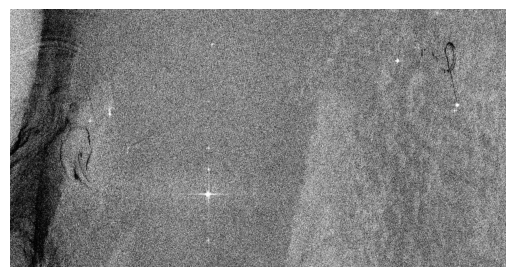

Randomly selected image: img_0006.jpg


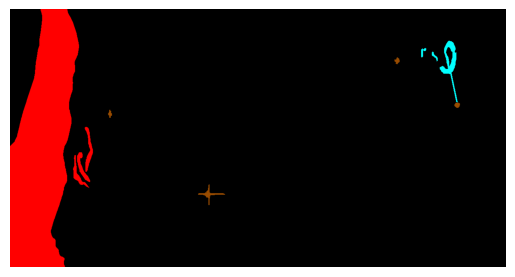

Randomly selected mask: img_0006.png


In [5]:
random_image_name = IMG_IDS[5]
random_mask_name = LABELS_IDS[5]

# Construct the full image path
image_path = os.path.join(IMG_PATH, random_image_name)
mask_path = os.path.join(LABELS_PATH, random_mask_name)

# Read and plot the image
img = mpimg.imread(image_path)
mask = mpimg.imread(mask_path)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Randomly selected image:", random_image_name)

plt.imshow(mask)
plt.axis('off')
plt.show()

print("Randomly selected mask:", random_mask_name)

In [6]:
COLOR_MAP = [
    [0, 0, 0], 
    [0, 255, 255], 
    [255, 0, 0], 
    [153, 76, 0],
    [0, 153, 0],
]

def process_mask(rgb_mask, colormap):
    output_mask = []

    for i, color in enumerate(colormap):
        cmap = np.all(np.equal(rgb_mask, color), axis=-1)
        output_mask.append(cmap)

    output_mask = np.stack(output_mask, axis=-1)
    return output_mask

In [7]:
train_images = []
train_masks = []

test_images = []
test_masks = []

In [8]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS, LABELS_IDS),total = len(IMG_IDS)):
    image_path = os.path.join(IMG_PATH, image_filename)
    mask_path = os.path.join(LABELS_PATH, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    train_images.append(image)
    train_masks.append(grayscale_mask)

# Convert the lists to arrays
train_images = np.array(train_images)
train_masks = np.array(train_masks)

100%|██████████| 1002/1002 [00:53<00:00, 18.75it/s]


In [9]:
train_masks.shape

(1002, 256, 256, 1)

In [10]:
unique_values = np.unique(train_masks)
print("Unique values in train_masks:", unique_values)

Unique values in train_masks: [0 1 2 3 4]


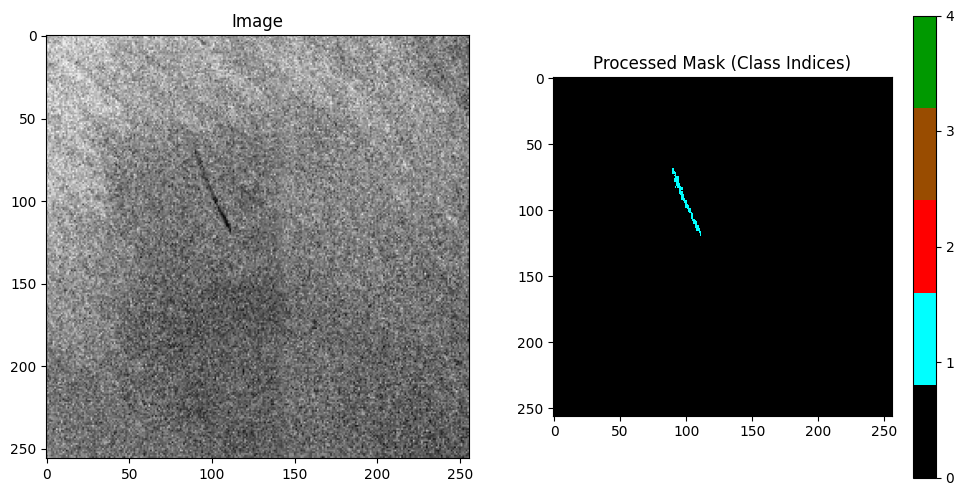

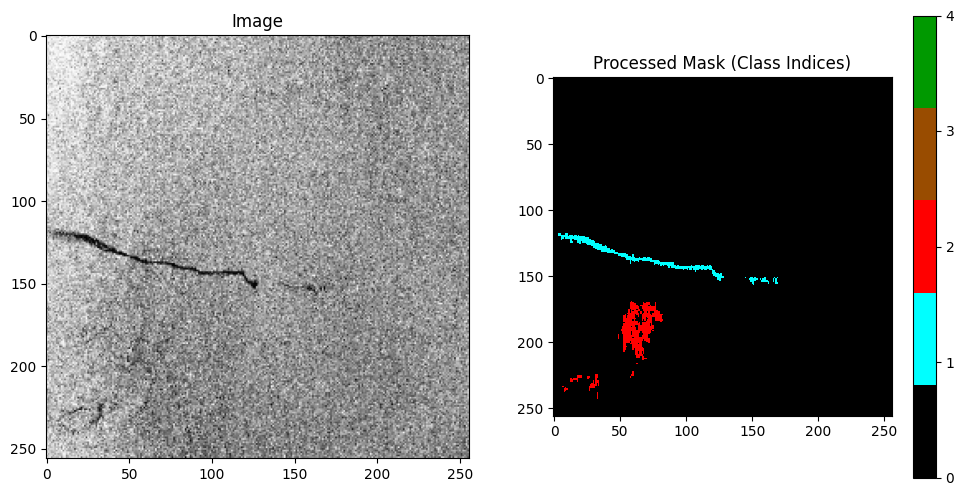

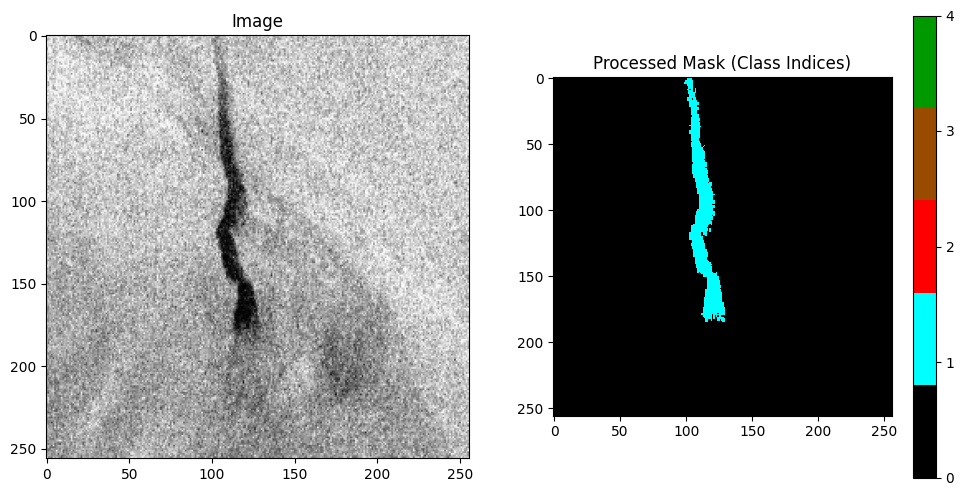

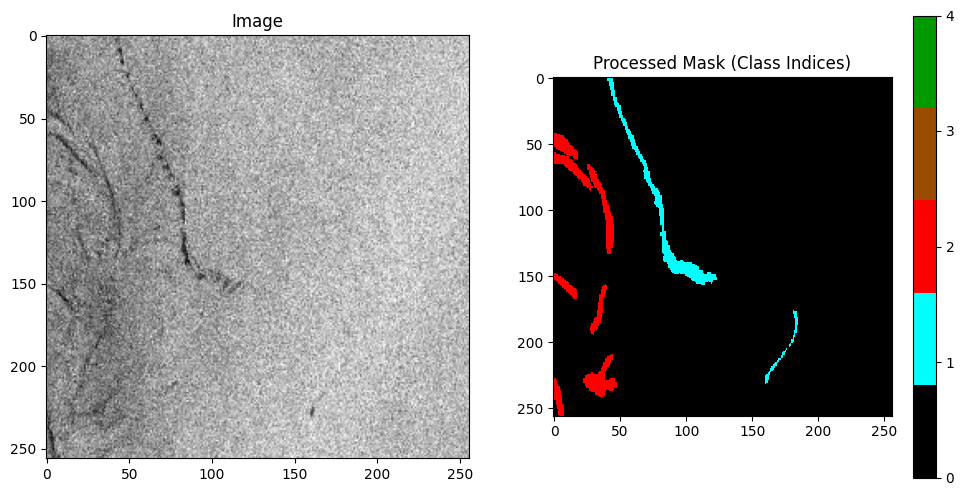

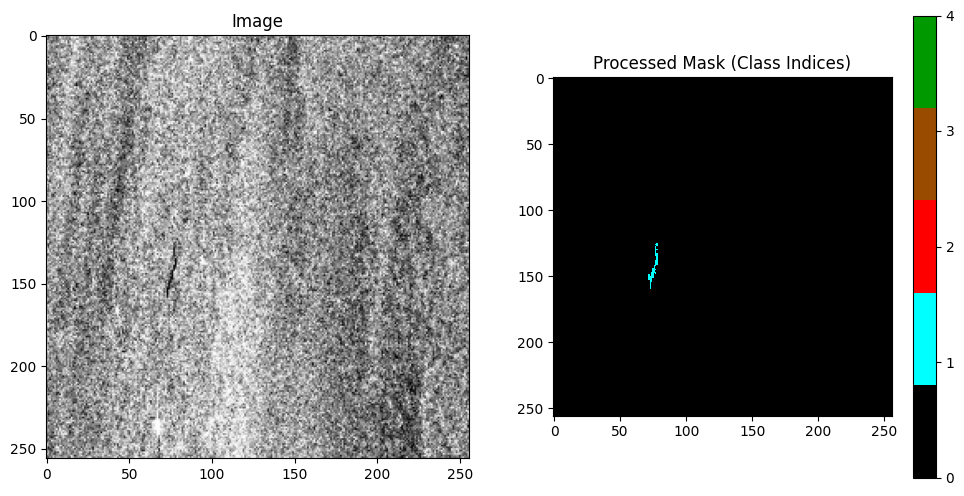

In [11]:
import matplotlib.colors as mcolors

# Scale the color values in COLOR_MAP to the range [0, 1]
scaled_color_map = [[c[0] / 255.0, c[1] / 255.0, c[2] / 255.0] for c in COLOR_MAP]

# Define a consistent color map based on the scaled COLOR_MAP
cmap = mcolors.ListedColormap(scaled_color_map)
num_images_to_plot = 5
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)  # Subplot for the image
    plt.imshow(train_images[i])  # Display the image
    plt.title("Image")

    plt.subplot(1, 2, 2)  # Subplot for the processed mask
    plt.imshow(train_masks[i].squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Processed Mask (Class Indices)")

    plt.show()

In [12]:
for image_filename, mask_filename in tqdm(zip(IMG_IDS_TEST, LABELS_IDS_TEST),total = len(IMG_IDS_TEST)):
    image_path = os.path.join(IMG_PATH_TEST, image_filename)
    mask_path = os.path.join(LABELS_PATH_TEST, mask_filename)

    image = cv2.imread(image_path,cv2.IMREAD_COLOR)

    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # normalizing the image
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    processed_mask = process_mask(mask,COLOR_MAP)
    grayscale_mask = np.argmax(processed_mask, axis=-1)
    grayscale_mask = np.expand_dims(grayscale_mask, axis=-1)

    test_images.append(image)
    test_masks.append(grayscale_mask)

# Convert the lists to np arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

100%|██████████| 110/110 [00:05<00:00, 19.03it/s]


In [13]:
test_masks.shape

(110, 256, 256, 1)

In [14]:
unique_values = np.unique(test_masks)
print("Unique values in test_masks:", unique_values)

Unique values in test_masks: [0 1 2 3 4]


In [15]:
from keras.utils import to_categorical

train_masks = to_categorical(train_masks, num_classes = 5)

In [16]:
print(train_images.shape)
print(train_masks.shape)

(1002, 256, 256, 3)
(1002, 256, 256, 5)


In [17]:
print(test_images.shape)
print(test_masks.shape)

(110, 256, 256, 3)
(110, 256, 256, 1)


In [18]:
print(np.unique(train_masks))
print(np.unique(test_masks))

[0. 1.]
[0 1 2 3 4]


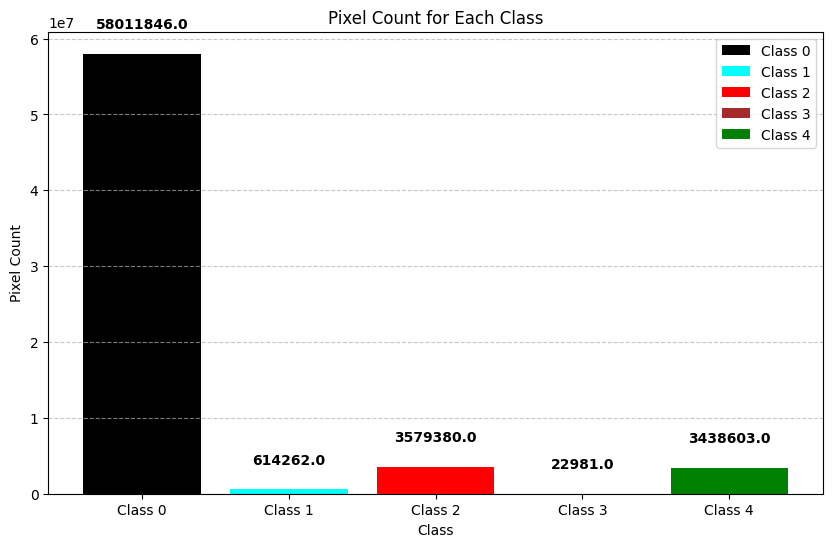

In [19]:
num_classes = 5

# Calculate pixel counts for each class
class_pixel_counts = np.sum(train_masks, axis=(0, 1, 2))

# Class labels
class_labels = [f'Class {i}' for i in range(num_classes)]

# Define different colors for each class
colors = ['black', 'cyan', 'red', 'brown', 'green']

# Plotting the bar graph with different colors and added styling
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, class_pixel_counts, color=colors)

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class')

# Adding legend
plt.legend(bars, class_labels)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value annotations on top of each bar
for bar, count in zip(bars, class_pixel_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05 * max(class_pixel_counts),
             f'{count}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [20]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# UNet

In [26]:
def UNet(input_shape, IMG_CLASSES):

    inputs = Input(input_shape)

    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

    outputs = Conv2D(IMG_CLASSES, (1,1), activation="softmax")(c9)

    model = Model(inputs, outputs)
    return model

In [25]:
unet_model = UNet(input_shape, IMG_CLASSES)

unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,173 (7.40 MB)

 Trainable params: 1,941,173 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
tf.keras.backend.clear_session()

unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [30]:
unet_history = unet_model.fit(train_images, train_masks,
                    epochs=100,
                    batch_size=16,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 349s 6s/step - accuracy: 0.8836 - loss: 0.4057 - precision: 0.8917 - recall: 0.8726 - val_accuracy: 0.9108 - val_loss: 0.3055 - val_precision: 0.9160 - val_recall: 0.9014
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 342s 6s/step - accuracy: 0.8900 - loss: 0.3575 - precision: 0.8987 - recall: 0.8793 - val_accuracy: 0.9140 - val_loss: 0.2559 - val_precision: 0.9219 - val_recall: 0.9059
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.8900 - loss: 0.3254 - precision: 0.8977 - recall: 0.8818 - val_accuracy: 0.9197 - val_loss: 0.2522 - val_precision: 0.9298 - val_recall: 0.9091
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 340s 6s/step - accuracy: 0.8875 - loss: 0.3336 - precision: 0.8963 - recall: 0.8779 - val_accuracy: 0.9179 - val_loss: 0.2282 - val_precision: 0.9227 - val_recall: 0.9135
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 341s 6s/step - accuracy: 0.8986 - loss: 0.3038 - precision: 0.9067 - recall: 0.8906 - val_accuracy: 0.9270 - val_loss: 0.

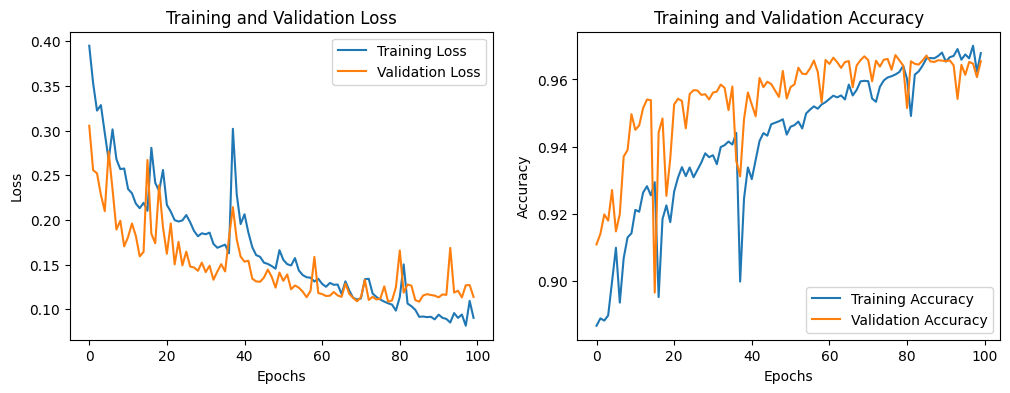

In [34]:
# Access the training history
unet_loss = unet_history.history['loss']
unet_val_loss = unet_history.history['val_loss']
unet_accuracy = unet_history.history['accuracy']
unet_val_accuracy = unet_history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(unet_loss, label='Training Loss')
plt.plot(unet_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(unet_accuracy, label='Training Accuracy')
plt.plot(unet_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


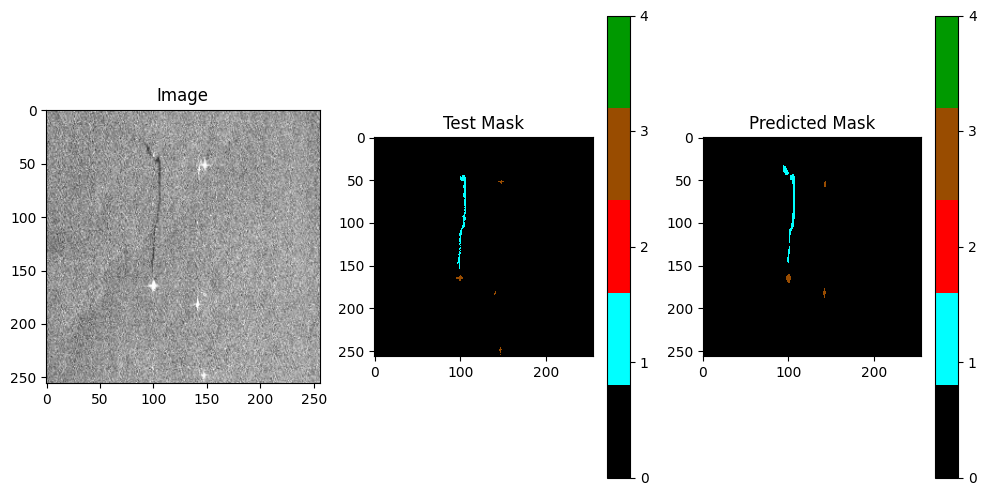

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


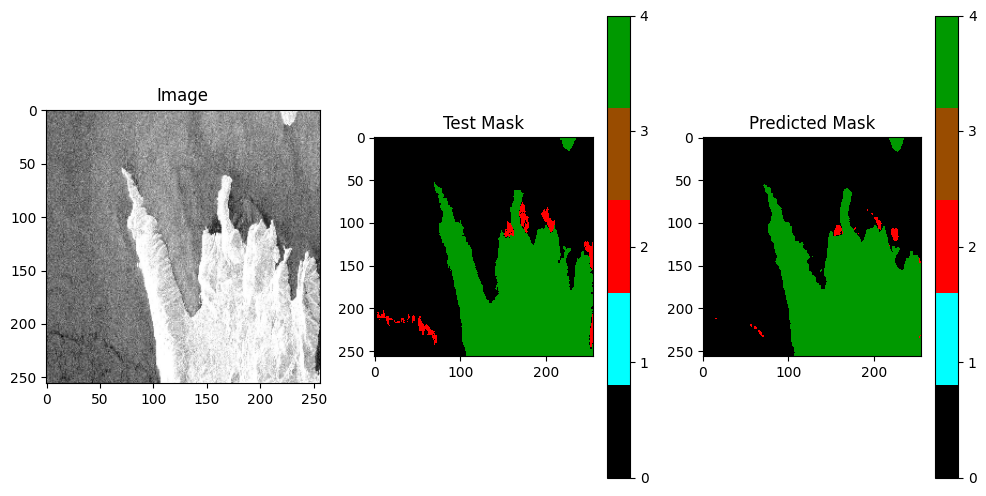

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


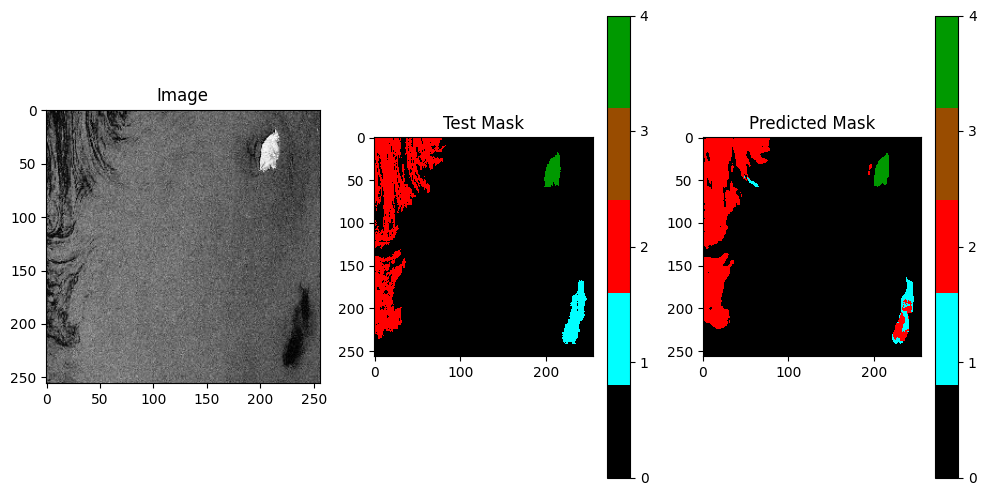

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


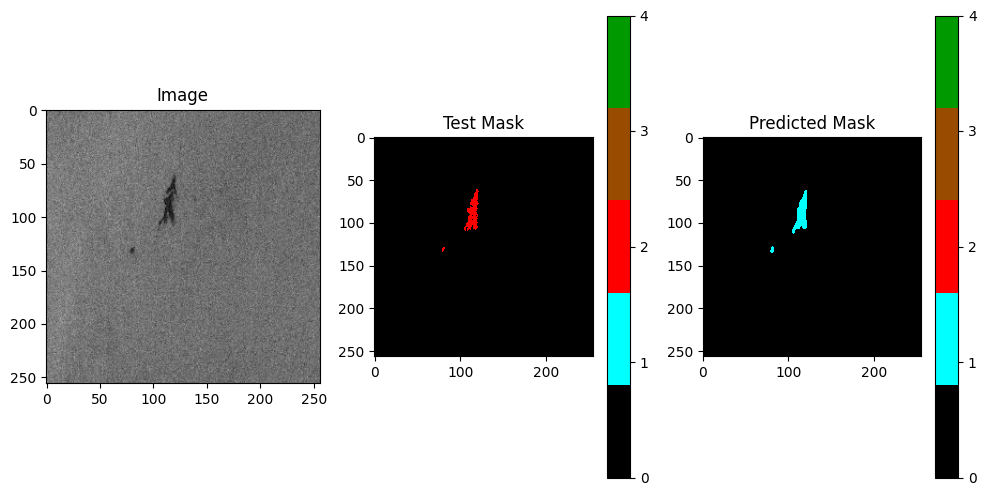

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


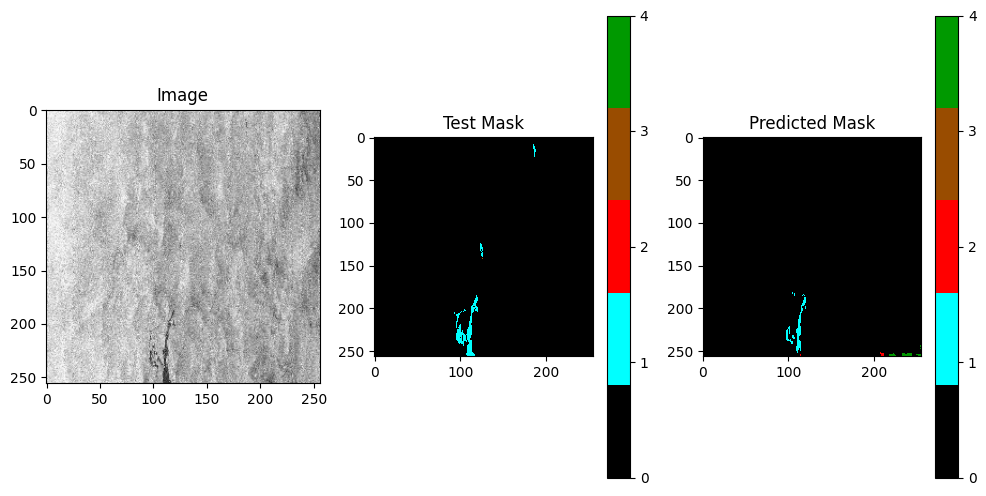

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


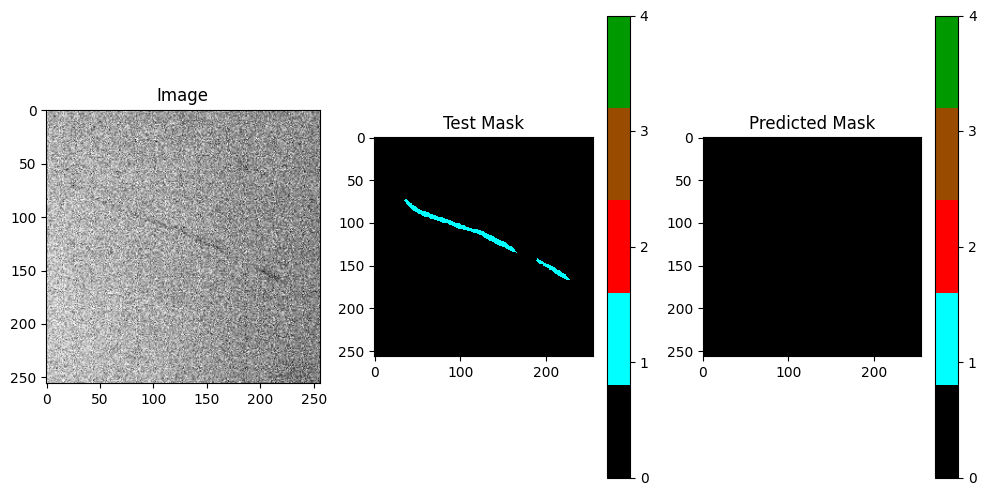

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


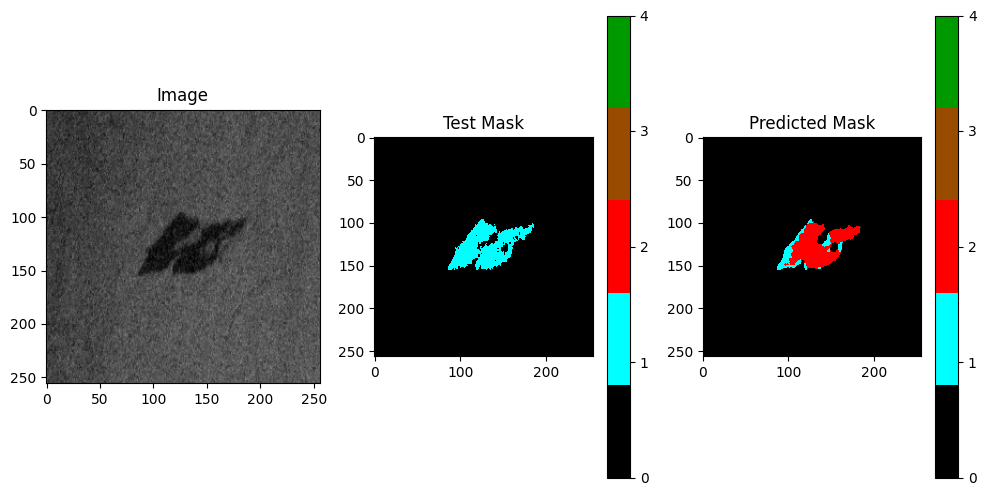

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


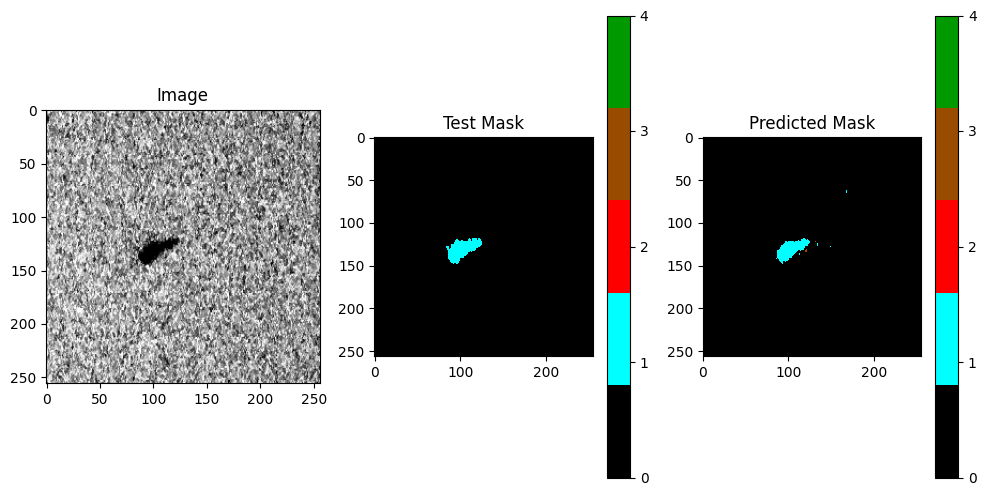

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


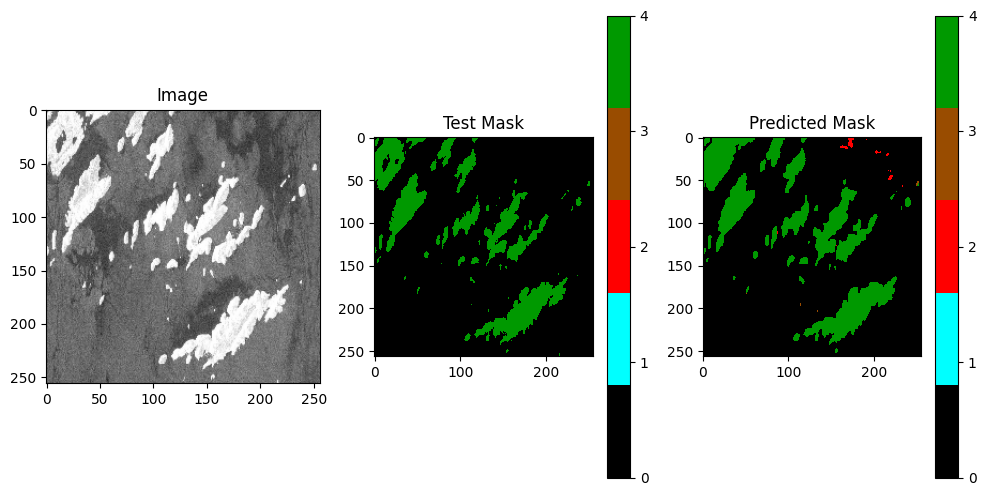

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


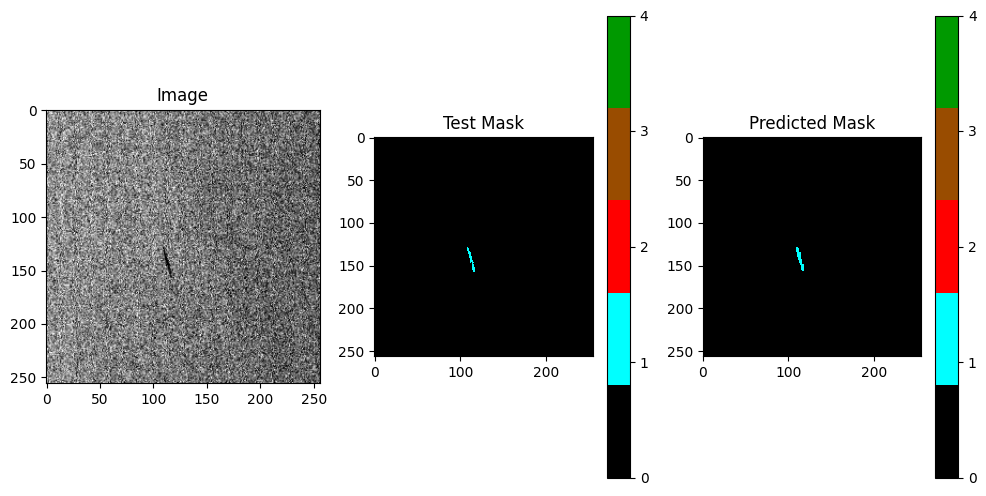

In [35]:
# Generate a random index within the range of test_images
test_image_number = random.randint(0, len(test_images) - 1)

num_images_to_plot = 10
for i in range(num_images_to_plot):
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    
    # Test Image 
    plt.subplot(1, 3, 1)  # Subplot for the image
    test_image = test_images[i]
    plt.imshow(test_image)  # Display the image
    plt.title("Image")
    
    # Test Mask
    plt.subplot(1, 3, 2)  # Subplot for the test mask
    test_mask = test_masks[i]
    plt.imshow(test_mask.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Test Mask")
    
    # Predicted Mask
    plt.subplot(1, 3, 3)  # Subplot for the predicted mask
    prediction_unet = unet_model.predict(np.expand_dims(test_image, axis=0))
    predicted_mask_unet = np.argmax(prediction_unet, axis=3)[0, :, :]
    plt.imshow(predicted_mask_unet.squeeze(), cmap=cmap, vmin=0, vmax=len(COLOR_MAP) - 1, interpolation='none')
    plt.colorbar(ticks=range(len(COLOR_MAP)))
    plt.title("Predicted Mask")
    
    plt.show()

In [36]:
prediction_unet = unet_model.predict(test_images)

print(test_masks.shape)
print(prediction_unet.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
(110, 256, 256, 1)
(110, 256, 256, 5)


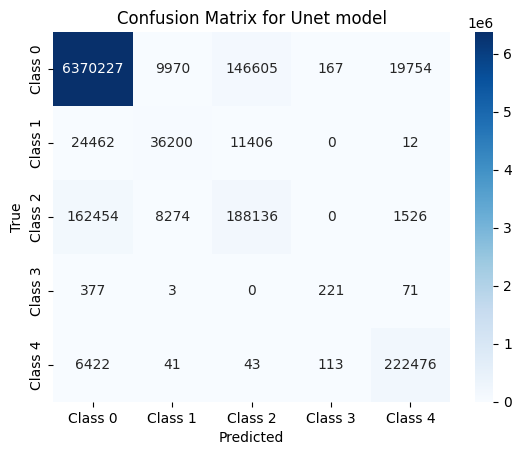

In [37]:
# Flatten the arrays to 1D
unet_true_labels = test_masks.flatten()
unet_predicted_labels = np.argmax(prediction_unet, axis=-1).flatten()

# Create the confusion matrix
cm = confusion_matrix(unet_true_labels, unet_predicted_labels)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Unet model')
plt.show()

In [38]:
# Calculate precision, recall, and F1 score
precision = precision_score(unet_true_labels, unet_predicted_labels, average='weighted')
recall = recall_score(unet_true_labels, unet_predicted_labels, average='weighted')
f1 = f1_score(unet_true_labels, unet_predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9442
Recall: 0.9457
F1 Score: 0.9448


# DeepLabV3Plus

In [48]:
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [49]:
def DeepLabV3Plus(input_shape, IMG_CLASSES):
    # Inputs
    inputs = layers.Input(input_shape)

    # Pre-trained ResNet50
    base_model = ResNet50(weights='/kaggle/input/resnet-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_tensor=inputs)
    

    # Pre-trained ResNet50 Output
    #wt path
    
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    # Get low-level features
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    # Outputs
    x = Conv2D(IMG_CLASSES, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    # Model
    model = Model(inputs=inputs, outputs=x)
    return model

In [50]:
deeplab_model = DeepLabV3Plus(input_shape, IMG_CLASSES)
deeplab_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 17,831,237 (68.02 MB)

 Trainable params: 17,796,453 (67.89 MB)

 Non-trainable params: 34,784 (135.88 KB)

In [51]:
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value




In [52]:
# treating all classes equally in terms of their contribution to the loss.
class_weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666]


In [55]:
%pip install segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss(class_weights = class_weights)
focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + focal_loss

#matrix to list

^C
Note: you may need to restart the kernel to use updated packages.


ModuleNotFoundError: No module named 'segmentation_models'

In [ ]:
tf.keras.backend.clear_session()

# # Define the learning rate
# learning_rate = 10e-5

# # Create an instance of the Adam optimizer with the specified learning rate
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

deeplab_model.compile(optimizer='adam', loss=total_loss, metrics = ["accuracy", jaccard_coef])